In [1]:
import sys
sys.path.insert(0, '../')

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import interpolate
from scipy.signal import butter, sosfiltfilt, find_peaks
from sklearn.linear_model import LinearRegression
from utils import *

%matplotlib inline
mpl.rcParams['lines.linewidth'] = 0.5
mpl.rcParams['font.family'] = 'arial'
mpl.rcParams['font.size'] = 14
np.set_printoptions(threshold=sys.maxsize,
                    suppress=True)

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(1)

Load the data, label the data, and prepare the data for LSTM

(-1.0, 2.0)

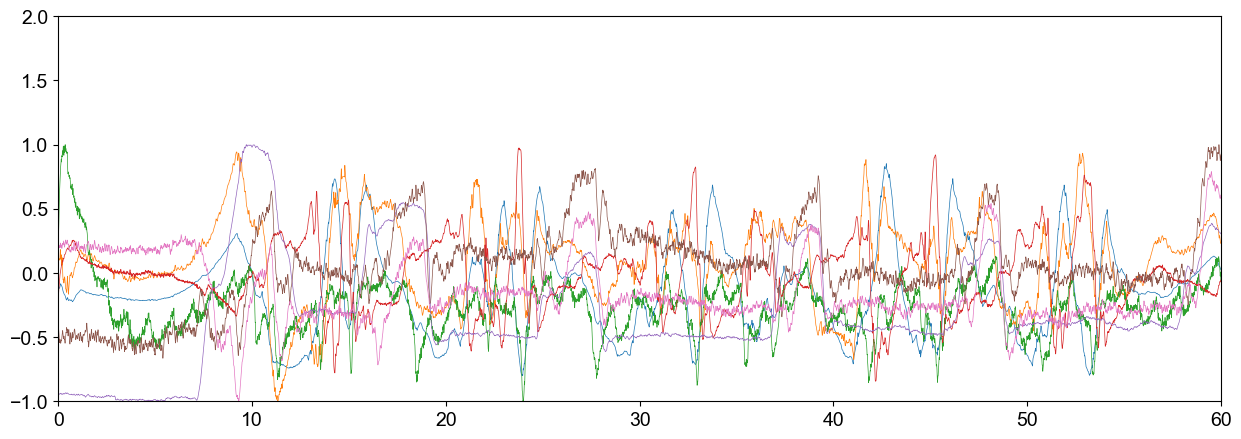

In [2]:
date_1 = '20230519'
filename_1 = 'swallow.txt'
fs = 1000.

timestamp1, c1, b1, tl1, tr1 = load_pv(date_1, filename_1)
pv_len = len(timestamp1)

timestamp1_o, y1, p1, r1 = load_ori(date_1, filename_1, 400)
timestamp1_o1, ypr_new = upsample(timestamp1_o, np.vstack((y1, p1, r1)), ratio=9.73)
ori_len = len(timestamp1_o1)

if pv_len < ori_len:
    timestamp1_o1 = timestamp1_o1[:pv_len]
    y1 = ypr_new[0, :pv_len]
    p1 = ypr_new[1, :pv_len]
    r1 = ypr_new[2, :pv_len]
else:
    timestamp1 = timestamp1[:ori_len]
    c1 = c1[:ori_len]
    b1 = b1[:ori_len]
    tl1 = tl1[:ori_len]
    tr1 = tr1[:ori_len]
    y1 = ypr_new[0, :]
    p1 = ypr_new[1, :]
    r1 = ypr_new[2, :]

# detrend
y1 = detrend(y1)
p1 = detrend(p1)
r1 = detrend(r1)

# despike
c1 = despike(c1, 500, 1)
b1 = despike(b1, 500, 1)
tl1 = despike(tl1, 500, 1)
tr1 = despike(tr1, 500, 1)
y1 = despike(y1, 100, 10)
p1 = despike(p1, 100, 10)
r1 = despike(r1, 100, 10)

# filter
sos = butter(3, [0.1, 30], btype='bandpass', fs=fs, output='sos')
c1_f = sosfiltfilt(sos, c1)
b1_f = sosfiltfilt(sos, b1)
tl1_f = sosfiltfilt(sos, tl1)
tr1_f = sosfiltfilt(sos, tr1)
# y1_f = sosfiltfilt(sos, y1)
# p1_f = sosfiltfilt(sos, p1)
# r1_f = sosfiltfilt(sos, r1)

# normalize
c1_n = normalize(c1_f)
b1_n = normalize(b1_f)
tl1_n = normalize(tl1_f)
tr1_n = normalize(tr1_f)
# y1_n = normalize(y1_f)
# p1_n = normalize(p1_f)
# r1_n = normalize(r1_f)
y1_n = normalize(y1)
p1_n = normalize(p1)
r1_n = normalize(r1)

# change everything to torch from here
data1_train = torch.tensor(np.vstack((c1_n,
                                      b1_n,
                                      tl1_n,
                                      tr1_n,
                                      y1_n,
                                      p1_n,
                                      r1_n)).T)

fig = plt.figure(figsize=[15, 5])
ax = fig.add_subplot()
ax.plot(timestamp1, data1_train)

ax.set_xlim(0, 60)
ax.set_ylim(-1, 2)

(-1.0, 2.0)

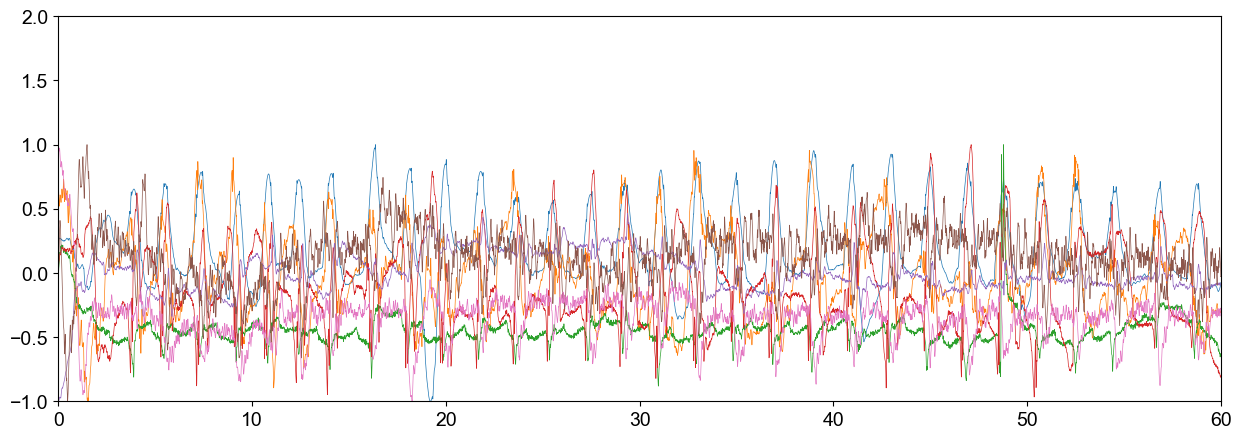

In [3]:
date_2 = '20230519'
filename_2 = 'dry_cough1.txt'
fs = 1000.

timestamp2, c2, b2, tl2, tr2 = load_pv(date_2, filename_2)
pv_len = len(timestamp2)

timestamp2_o, y2, p2, r2 = load_ori(date_2, filename_2, 100)
timestamp2_o1, ypr_new = upsample(timestamp2_o, np.vstack((y2, p2, r2)), ratio=9.73)
ori_len = len(timestamp2_o1)

if pv_len < ori_len:
    timestamp2_o1 = timestamp2_o1[:pv_len]
    y2 = ypr_new[0, :pv_len]
    p2 = ypr_new[1, :pv_len]
    r2 = ypr_new[2, :pv_len]
else:
    timestamp2 = timestamp2[:ori_len]
    c2 = c2[:ori_len]
    b2 = b2[:ori_len]
    tl2 = tl2[:ori_len]
    tr2 = tr2[:ori_len]
    y2 = ypr_new[0, :]
    p2 = ypr_new[1, :]
    r2 = ypr_new[2, :]

# detrend
y2 = detrend(y2)
p2 = detrend(p2)
r2 = detrend(r2)

# despike
c2 = despike(c2, 500, 1)
b2 = despike(b2, 500, 1)
tl2 = despike(tl2, 500, 1)
tr2 = despike(tr2, 500, 1)
y2 = despike(y2, 100, 10)
p2 = despike(p2, 100, 10)
r2 = despike(r2, 100, 10)

# filter
sos = butter(3, [0.1, 30], btype='bandpass', fs=fs, output='sos')
c2_f = sosfiltfilt(sos, c2)
b2_f = sosfiltfilt(sos, b2)
tl2_f = sosfiltfilt(sos, tl2)
tr2_f = sosfiltfilt(sos, tr2)

# normalize
c2_n = normalize(c2_f)
b2_n = normalize(b2_f)
tl2_n = normalize(tl2_f)
tr2_n = normalize(tr2_f)
y2_n = normalize(y2)
p2_n = normalize(p2)
r2_n = normalize(r2)

# change everything to torch from here
data2_train = torch.tensor(np.vstack((c2_n,
                                      b2_n,
                                      tl2_n,
                                      tr2_n,
                                      y2_n,
                                      p2_n,
                                      r2_n)).T)

fig = plt.figure(figsize=[15, 5])
ax = fig.add_subplot()
ax.plot(timestamp2, data2_train)

ax.set_xlim(0, 60)
ax.set_ylim(-1, 2)

(-1.0, 2.0)

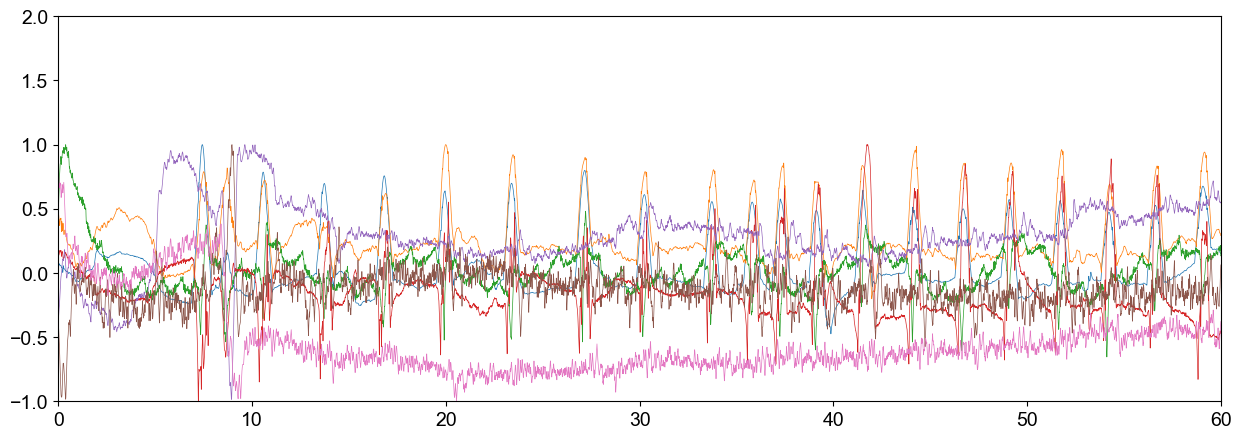

In [4]:
date_3 = '20230519'
filename_3 = 'throat_clearing2.txt'
fs = 1000.

timestamp3, c3, b3, tl3, tr3 = load_pv(date_3, filename_3)
pv_len = len(timestamp3)

timestamp3_o, y3, p3, r3 = load_ori(date_3, filename_3, 100)
timestamp3_o1, ypr_new = upsample(timestamp3_o, np.vstack((y3, p3, r3)), ratio=9.73)
ori_len = len(timestamp3_o1)

if pv_len < ori_len:
    timestamp3_o1 = timestamp3_o1[:pv_len]
    y3 = ypr_new[0, :pv_len]
    p3 = ypr_new[1, :pv_len]
    r3 = ypr_new[2, :pv_len]
else:
    timestamp3 = timestamp3[:ori_len]
    c3 = c3[:ori_len]
    b3 = b3[:ori_len]
    tl3 = tl3[:ori_len]
    tr3 = tr3[:ori_len]
    y3 = ypr_new[0, :]
    p3 = ypr_new[1, :]
    r3 = ypr_new[2, :]

# detrend
y3 = detrend(y3)
p3 = detrend(p3)
r3 = detrend(r3)

# despike
c3 = despike(c3, 500, 1)
b3 = despike(b3, 500, 1)
tl3 = despike(tl3, 500, 1)
tr3 = despike(tr3, 500, 1)
y3 = despike(y3, 100, 10)
p3 = despike(p3, 100, 10)
r3 = despike(r3, 100, 10)

# filter
sos = butter(3, [0.1, 30], btype='bandpass', fs=fs, output='sos')
c3_f = sosfiltfilt(sos, c3)
b3_f = sosfiltfilt(sos, b3)
tl3_f = sosfiltfilt(sos, tl3)
tr3_f = sosfiltfilt(sos, tr3)

# normalize
c3_n = normalize(c3_f)
b3_n = normalize(b3_f)
tl3_n = normalize(tl3_f)
tr3_n = normalize(tr3_f)
y3_n = normalize(y3)
p3_n = normalize(p3)
r3_n = normalize(r3)

# change everything to torch from here
data3_train = torch.tensor(np.vstack((c3_n,
                                      b3_n,
                                      tl3_n,
                                      tr3_n,
                                      y3_n,
                                      p3_n,
                                      r3_n)).T)

fig = plt.figure(figsize=[15, 5])
ax = fig.add_subplot()
ax.plot(timestamp3, data3_train)

ax.set_xlim(0, 60)
ax.set_ylim(-1, 2)

(-1.0, 2.0)

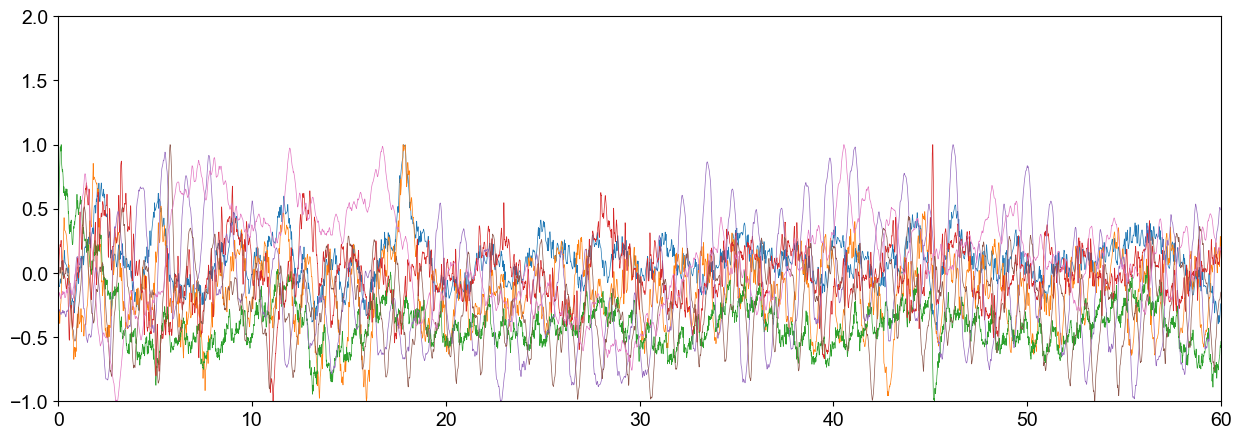

In [5]:
date_4 = '20230519'
filename_4 = 'walking.txt'
fs = 1000.

timestamp4, c4, b4, tl4, tr4 = load_pv(date_4, filename_4)
pv_len = len(timestamp4)

timestamp4_o, y4, p4, r4 = load_ori(date_4, filename_4, 100)
timestamp4_o1, ypr_new = upsample(timestamp4_o, np.vstack((y4, p4, r4)), ratio=9.73)
ori_len = len(timestamp4_o1)

if pv_len < ori_len:
    timestamp4_o1 = timestamp4_o1[:pv_len]
    y4 = ypr_new[0, :pv_len]
    p4 = ypr_new[1, :pv_len]
    r4 = ypr_new[2, :pv_len]
else:
    timestamp4 = timestamp4[:ori_len]
    c4 = c4[:ori_len]
    b4 = b4[:ori_len]
    tl4 = tl4[:ori_len]
    tr4 = tr4[:ori_len]
    y4 = ypr_new[0, :]
    p4 = ypr_new[1, :]
    r4 = ypr_new[2, :]

# detrend
y4 = detrend(y4)
p4 = detrend(p4)
r4 = detrend(r4)

# despike
c4 = despike(c4, 500, 1)
b4 = despike(b4, 500, 1)
tl4 = despike(tl4, 500, 1)
tr4 = despike(tr4, 500, 1)
y4 = despike(y4, 100, 10)
p4 = despike(p4, 100, 10)
r4 = despike(r4, 100, 10)

# filter
sos = butter(3, [0.1, 30], btype='bandpass', fs=fs, output='sos')
c4_f = sosfiltfilt(sos, c4)
b4_f = sosfiltfilt(sos, b4)
tl4_f = sosfiltfilt(sos, tl4)
tr4_f = sosfiltfilt(sos, tr4)
# y1_f = sosfiltfilt(sos, y4)
# p1_f = sosfiltfilt(sos, p4)
# r1_f = sosfiltfilt(sos, r4)

# normalize
c4_n = normalize(c4_f)
b4_n = normalize(b4_f)
tl4_n = normalize(tl4_f)
tr4_n = normalize(tr4_f)
# y4_n = normalize(y1_f)
# p4_n = normalize(p1_f)
# r4_n = normalize(r1_f)
y4_n = normalize(y4)
p4_n = normalize(p4)
r4_n = normalize(r4)

# change everything to torch from here
data4_train = torch.tensor(np.vstack((c4_n,
                                      b4_n,
                                      tl4_n,
                                      tr4_n,
                                      y4_n,
                                      p4_n,
                                      r4_n)).T)

fig = plt.figure(figsize=[15, 5])
ax = fig.add_subplot()
ax.plot(timestamp4, data4_train)

ax.set_xlim(0, 60)
ax.set_ylim(-1, 2)


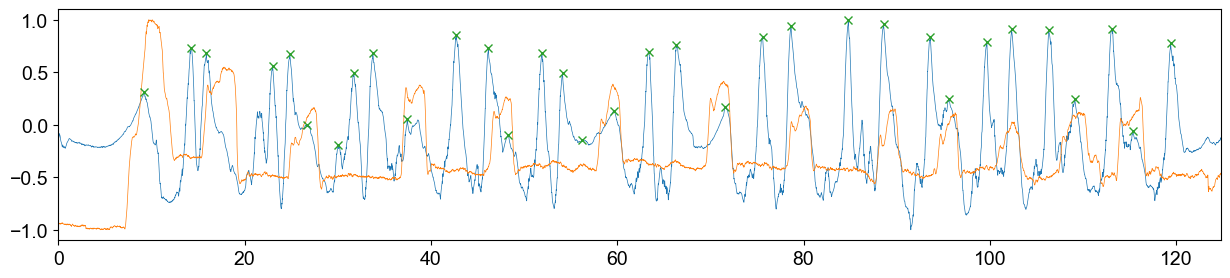

torch.Size([12, 7, 1000])

In [6]:
# swallow
peaks, _ = find_peaks(c1_n, distance=1.5*fs, width=0.5*fs)

fig, ax = plt.subplots(figsize=[15, 3])
ax.plot(timestamp1, c1_n)
ax.plot(timestamp1, y1_n)
ax.plot(timestamp1[peaks], c1_n[peaks], 'x')
ax.set_xlim(0, len(timestamp1)/fs)
plt.show()

# swallow manipulation
peaks = peaks[[1, 3, 7, 10, 13, 17, 20, 22, 26, 28, 30, 32]]

# form windows
peak_window = 1000

expanded_peaks = peak_expand(peaks, peak_window, len(timestamp1))
c1_s = c1_n[expanded_peaks]
b1_s = b1_n[expanded_peaks]
tl1_s = tl1_n[expanded_peaks]
tr1_s = tr1_n[expanded_peaks]
y1_s = y1_n[expanded_peaks]
p1_s = p1_n[expanded_peaks]
r1_s = r1_n[expanded_peaks]

data1 = torch.tensor(np.transpose(np.stack((c1_s,
                                            b1_s,
                                            tl1_s,
                                            tr1_s,
                                            y1_s,
                                            p1_s,
                                            r1_s)),
                                  (1, 0, 2)))
data1.shape

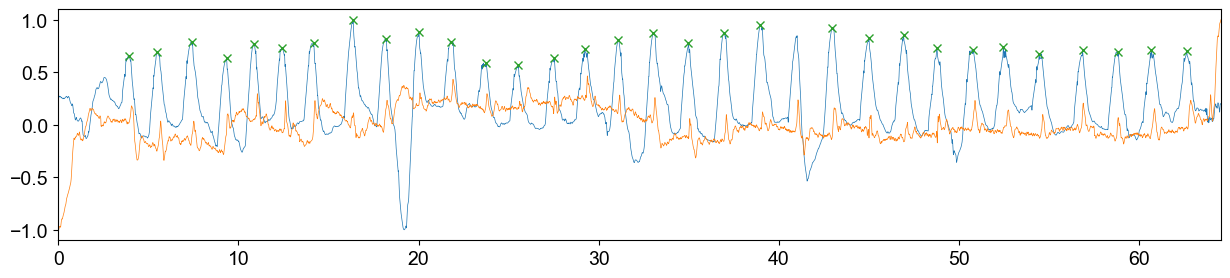

torch.Size([31, 7, 1000])

In [7]:
# dry cough
peaks, _ = find_peaks(c2_n, distance=1.5*fs, width=0.5*fs)

fig, ax = plt.subplots(figsize=[15, 3])
ax.plot(timestamp2, c2_n)
ax.plot(timestamp2, y2_n)
ax.plot(timestamp2[peaks], c2_n[peaks], 'x')
ax.set_xlim(0, len(timestamp2)/fs)
plt.show()

expanded_peaks = peak_expand(peaks, peak_window, len(timestamp1))
c2_s = c2_n[expanded_peaks]
b2_s = b2_n[expanded_peaks]
tl2_s = tl2_n[expanded_peaks]
tr2_s = tr2_n[expanded_peaks]
y2_s = y2_n[expanded_peaks]
p2_s = p2_n[expanded_peaks]
r2_s = r2_n[expanded_peaks]

data2 = torch.tensor(np.transpose(np.stack((c2_s,
                                            b2_s,
                                            tl2_s,
                                            tr2_s,
                                            y2_s,
                                            p2_s,
                                            r2_s)),
                                  (1, 0, 2)))
data2.shape

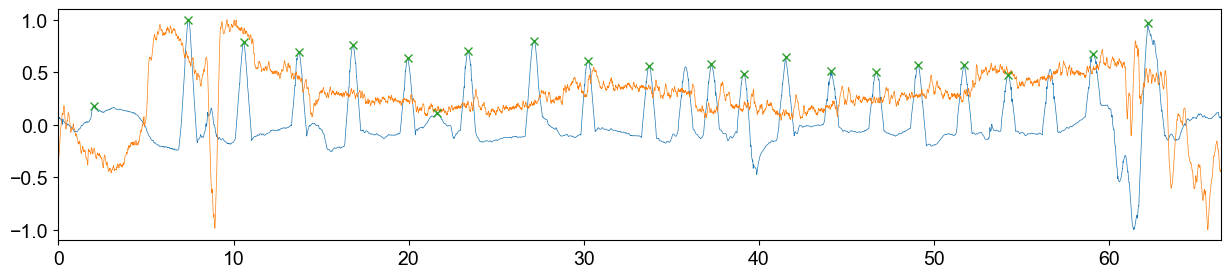

torch.Size([21, 7, 1000])

In [8]:
# throat clearing
peaks, _ = find_peaks(c3_n, distance=1.5*fs, width=0.5*fs)

fig, ax = plt.subplots(figsize=[15, 3])
ax.plot(timestamp3, c3_n)
ax.plot(timestamp3, y3_n)
ax.plot(timestamp3[peaks], c3_n[peaks], 'x')
ax.set_xlim(0, len(timestamp3)/fs)
plt.show()

expanded_peaks = peak_expand(peaks, peak_window, len(timestamp1))
c3_s = c3_n[expanded_peaks]
b3_s = b3_n[expanded_peaks]
tl3_s = tl3_n[expanded_peaks]
tr3_s = tr3_n[expanded_peaks]
y3_s = y3_n[expanded_peaks]
p3_s = p3_n[expanded_peaks]
r3_s = r3_n[expanded_peaks]

data3 = torch.tensor(np.transpose(np.stack((c3_s,
                                            b3_s,
                                            tl3_s,
                                            tr3_s,
                                            y3_s,
                                            p3_s,
                                            r3_s)),
                                  (1, 0, 2)))
data3.shape

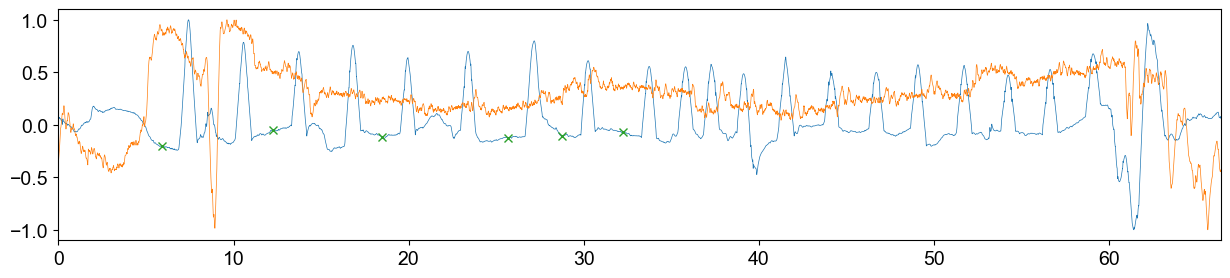

torch.Size([6, 7, 1000])

In [26]:
# quiet
peaks, _ = find_peaks(c3_n, distance=1.5*fs, width=0.5*fs)
shift = int(1.5*fs)

# quiet manipulation
peaks = peaks[[1, 3, 5, 8, 9, 10]]

fig, ax = plt.subplots(figsize=[15, 3])
ax.plot(timestamp3, c3_n)
ax.plot(timestamp3, y3_n)
ax.plot(timestamp3[peaks-shift], c3_n[peaks-shift], 'x')
ax.set_xlim(0, len(timestamp3)/fs)
plt.show()

expanded_peaks = peak_shift(peaks, shift, peak_window, len(timestamp1))
c5_s = c3_n[expanded_peaks]
b5_s = b3_n[expanded_peaks]
tl5_s = tl3_n[expanded_peaks]
tr5_s = tr3_n[expanded_peaks]
y5_s = y3_n[expanded_peaks]
p5_s = p3_n[expanded_peaks]
r5_s = r3_n[expanded_peaks]

data5 = torch.tensor(np.transpose(np.stack((c5_s,
                                            b5_s,
                                            tl5_s,
                                            tr5_s,
                                            y5_s,
                                            p5_s,
                                            r5_s)),
                                  (1, 0, 2)))
data5.shape

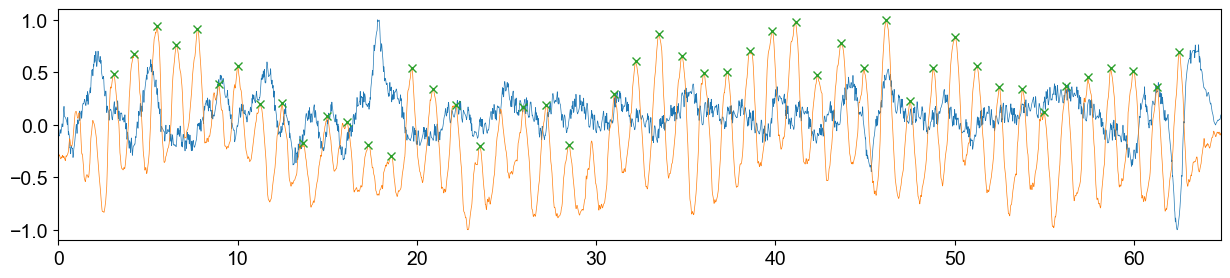

torch.Size([47, 7, 1000])

In [11]:
# walking
peaks, _ = find_peaks(y4_n, distance=1*fs, width=0.5*fs)

fig, ax = plt.subplots(figsize=[15, 3])
ax.plot(timestamp4, c4_n)
ax.plot(timestamp4, y4_n)
ax.plot(timestamp4[peaks], y4_n[peaks], 'x')
ax.set_xlim(0, len(timestamp4)/fs)
plt.show()

expanded_peaks = peak_expand(peaks, peak_window, len(timestamp1))
c4_s = c4_n[expanded_peaks]
b4_s = b4_n[expanded_peaks]
tl4_s = tl4_n[expanded_peaks]
tr4_s = tr4_n[expanded_peaks]
y4_s = y4_n[expanded_peaks]
p4_s = p4_n[expanded_peaks]
r4_s = r4_n[expanded_peaks]

data4 = torch.tensor(np.transpose(np.stack((c4_s,
                                            b4_s,
                                            tl4_s,
                                            tr4_s,
                                            y4_s,
                                            p4_s,
                                            r4_s)),
                                  (1, 0, 2)))
data4.shape

In [27]:
labels = torch.cat((torch.zeros(data5.shape[0]),
                    torch.ones(data1.shape[0]),
                    2*torch.ones(data2.shape[0]),
                    3*torch.ones(data3.shape[0]),
                    4*torch.ones(data4.shape[0])),
                    dim=0)

features = torch.cat((data5, data1, data2, data3, data4), dim=0)

In [28]:
class PharyngealDataset(torch.utils.data.Dataset):
    
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels
    
    def __len__(self):
        return self.features.shape[0]
    
    def __getitem__(self, idx):
        return self.features[idx,...], self.labels[idx]
    
my_dataset = PharyngealDataset(features, labels)

In [29]:
print(features.shape)
print(labels.shape)

torch.Size([117, 7, 1000])
torch.Size([117])


In [31]:
torch.save(my_dataset, '../dataset/data_train/20230519.pt')

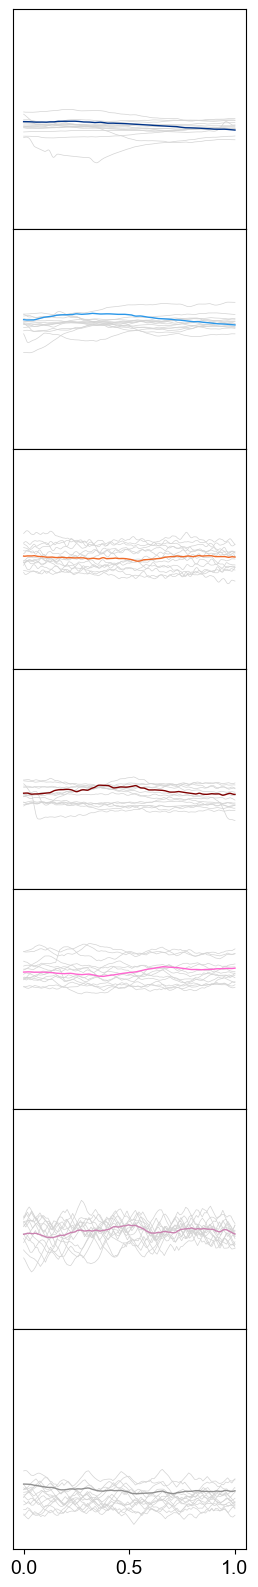

In [24]:
def channel_plot(ax, arr_s, to_delete):
    arr_sa = np.delete(arr_s, np.where(to_delete > 0)[0], axis=0)
    for window in arr_sa:
        line = ax.plot(np.linspace(0, 1, peak_window), window, c='lightgray')
        ax.set_ylim([-1.2, 1.2])
    return line

c1_td = section_average(c1_s)
b1_td = section_average(b1_s)
tl1_td = section_average(tl1_s)
tr1_td = section_average(tr1_s)
y1_td = section_average(y1_s)
p1_td = section_average(p1_s)
r1_td = section_average(r1_s)
# to_delete = c1_td + b1_td + tl1_td + tr1_td + y1_td + p1_td + r1_td
# all_s = np.array([c1_s, b1_s, tl1_s, tr1_s, y1_s, p1_s, r1_s])

c2_td = section_average(c2_s)
b2_td = section_average(b2_s)
tl2_td = section_average(tl2_s)
tr2_td = section_average(tr2_s)
y2_td = section_average(y2_s)
p2_td = section_average(p2_s)
r2_td = section_average(r2_s)
# to_delete = c2_td + b2_td + tl2_td + tr2_td + y2_td + p2_td + r2_td
# all_s = np.array([c2_s, b2_s, tl2_s, tr2_s, y2_s, p2_s, r2_s])

c3_td = section_average(c3_s)
b3_td = section_average(b3_s)
tl3_td = section_average(tl3_s)
tr3_td = section_average(tr3_s)
y3_td = section_average(y3_s)
p3_td = section_average(p3_s)
r3_td = section_average(r3_s)
# to_delete = c3_td + b3_td + tl3_td + tr3_td + y3_td + p3_td + r3_td
# all_s = np.array([c3_s, b3_s, tl3_s, tr3_s, y3_s, p3_s, r3_s])

c4_td = section_average(c4_s)
b4_td = section_average(b4_s)
tl4_td = section_average(tl4_s)
tr4_td = section_average(tr4_s)
y4_td = section_average(y4_s)
p4_td = section_average(p4_s)
r4_td = section_average(r4_s)
# to_delete = c4_td + b4_td + tl4_td + tr4_td + y4_td + p4_td + r4_td
# all_s = np.array([c4_s, b4_s, tl4_s, tr4_s, y4_s, p4_s, r4_s])

c5_td = section_average(c5_s)
b5_td = section_average(b5_s)
tl5_td = section_average(tl5_s)
tr5_td = section_average(tr5_s)
y5_td = section_average(y5_s)
p5_td = section_average(p5_s)
r5_td = section_average(r5_s)
to_delete = c5_td + b5_td + tl5_td + tr5_td + y5_td + p5_td + r5_td
all_s = np.array([c5_s, b5_s, tl5_s, tr5_s, y5_s, p5_s, r5_s])

pv_color = ['#003388', '#2a97e9', '#f06a28', '#7e0000']
or_color = ['#ff66d0', '#ca82b0', '#909090']
colors = pv_color + or_color

fig, axes = plt.subplots(nrows=7, ncols=1,
                         figsize=(3, 20),
                         sharex=True)
for idx, (ax, window) in enumerate(zip(axes.flatten(), all_s)):
    line = channel_plot(ax, window, to_delete)
    ax.plot(np.linspace(0, 1, peak_window), np.mean(window, axis=0), c=colors[idx], linewidth=1)
    # ax.set_xlim(0, 1)
    ax.set_yticks([])

plt.subplots_adjust(hspace=0)
plt.show()